In [2]:
#Dependencies
import requests
import json
from api_keys import api_key_FBI
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from pathlib import Path



In [3]:
# Abbreviation of every state.
state_codes = pd.DataFrame({"Abbreviation":['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC',
                'DE', 'FL', 'FS', 'GA', 'GM', 'HI', 'ID', 'IL', 'IN', 'IA',
                'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 
                'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 
                'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 
                'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 
                'TX', 'UT', 'VT', 'VA', 'WA', 'VI', 'WV', 'WI', 'WY']})

# Create dataframe with abbreviations and empty column for homicide data
data_homicide = state_codes.copy()
data_homicide["Total Homicide"] = ""

# FBI HOMICIDE DATA, 2021

In [4]:
# Access the FBI homicide API and add each state total to the dataframe
for index,row in data_homicide.iterrows():
    try:
        state=row["Abbreviation"]
        base_url=f"https://api.usa.gov/crime/fbi/cde/shr/state/{state}/victim/sex?from=2021&to=2021&API_KEY={api_key_FBI}"
        #print(base_url)
        response = requests.get(base_url)
        response= response.json()
# Add all genders together to get the total number of homicides
        data_homicide.loc[index,"Total Homicide"]=response["data"][0]["Unknown"]+response["data"][0]["Male"]+response["data"][0]["Female"]
    except:
        # For states with no data, enter a null value
        data_homicide.loc[index, "Total Homicide"] = None

In [5]:
# Drop rows with null values
data_homicide= data_homicide.dropna(how = "any")
# Change data type to integer
data_homicide["Total Homicide"] = data_homicide["Total Homicide"].astype(int)
# Sort values by number of homicides
data_homicide = data_homicide.sort_values("Total Homicide")

In [6]:
# Statistical overciew
data_homicide.describe()

,Total Homicide
count,49.00000
mean,297.77551
std,354.79444
min,6.00000
25%,85.00000
50%,169.00000
75%,438.00000
max,2064.00000


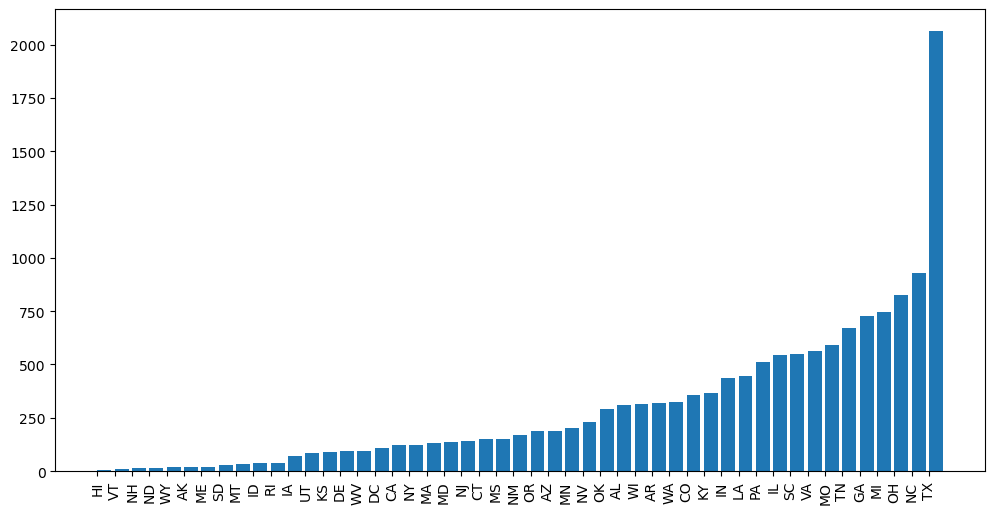

In [7]:
# Generate a bar plot showing the total number of homicides per state
plt.figure(figsize=(12, 6))
plt.bar(data_homicide["Abbreviation"], data_homicide["Total Homicide"], align = "edge")
plt.xticks(rotation = 90)
plt.show()

This table show the huge differences in total numbers of homicides between the states. We should not be surprised that Texas has such a high number when we consider the size of Texas. We need to bring in census data so that our homicide data can tell us more about the crime than the population. 

In [8]:
# Read in the census data
census_path = Path("Resources/census_data.csv")
census_df = pd.read_csv(census_path)

In [9]:
# Merge with homicide data
homicide_plus_census = pd.merge(data_homicide, census_df, on = "Abbreviation", how = "inner", 
                    left_index=False, right_index=False)
homicide_plus_census["Population"] = homicide_plus_census["Population"].astype(int)

In [10]:
# Find the homicide rate per 100,000 people
homicide_plus_census["Homicide Rate (per 100,000)"] = (homicide_plus_census["Total Homicide"] / 
                                                        homicide_plus_census["Population"]) * 100000

In [11]:
# Sort by Homicide Rate
homicide_rate_df = homicide_plus_census.sort_values("Homicide Rate (per 100,000)")

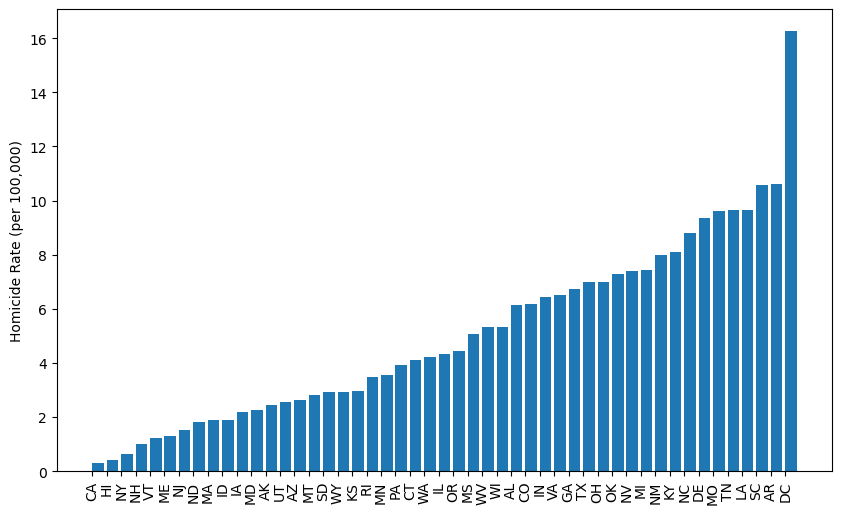

In [12]:
# Plot homicide rate for each state
plt.figure(figsize = (10, 6))
plt.bar(homicide_rate_df["Abbreviation"], homicide_rate_df["Homicide Rate (per 100,000)"], align = "edge")
plt.ylabel("Homicide Rate (per 100,000)")
plt.xticks(rotation = 90)
plt.show()

Now, we can see that there is still quite a big difference between states, but not the differences are not explained by size of the state. California, Hawaii, New York, New Hampshire, and Virginia are the states with the lowest homicide rate. Tennessee, Louisiana, South Carolina, Arkansas, and washington Dc have the highest rates. It is particularly surprising that the homicide rate is so high in Washington, DC. More research could be done to try to understand why this is. 

In [13]:
# Statistical Overview
homicide_rate_df["Homicide Rate (per 100,000)"].describe()

count    49.000000
mean      5.061576
std       3.376417
min       0.313473
25%       2.456758
50%       4.308893
75%       7.274298
max      16.267443
Name: Homicide Rate (per 100,000), dtype: float64

# COST OF LIVING 

In [14]:
# Read in the csv file
cost_living_data = pd.read_csv("resources/cost-of-living-index-by-state-[updated-june-2023].csv")

# Create a new DataFrame with the desired columns
cost_of_living = cost_living_data.loc[:, ["state", "2023", "GroceryCostsIndex", "HousingCostsIndex", "MiscCostsIndex", "TransportationCostsIndex", "UtilityCostsIndex"]]

# Rename the columns "2023" and "state" to "Cost of Living Index" and "State" respectively
cost_of_living.rename(columns={"2023": "Cost of Living Index", "state": "State"}, inplace=True)

# Display the new table
cost_of_living.head()

,State,Cost of Living Index,GroceryCostsIndex,HousingCostsIndex,MiscCostsIndex,TransportationCostsIndex,UtilityCostsIndex
0,Hawaii,179.0,125.6,309.7,123.8,140.3,141.1
1,District of Columbia,148.7,106.9,241.8,117.7,107.9,110.2
2,Massachusetts,148.4,105.0,219.5,125.8,127.5,126.1
3,California,134.5,112.3,186.5,110.9,124.1,124.8
4,New York,125.1,103.0,173.3,109.0,106.7,102.5


In [15]:
# Statistical Summary
cost_of_living.describe()

,Cost of Living Index,GroceryCostsIndex,HousingCostsIndex,MiscCostsIndex,TransportationCostsIndex,UtilityCostsIndex
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,104.001961,101.215686,109.049020,102.476471,102.611765,101.741176
std,18.240970,6.569395,46.903677,8.790531,10.902012,14.026406
min,85.300000,93.800000,68.000000,91.000000,88.300000,84.400000
25%,91.750000,97.300000,79.300000,96.250000,95.050000,92.700000
50%,96.500000,100.100000,92.100000,99.600000,99.400000,97.800000
75%,112.300000,103.000000,118.500000,106.450000,108.050000,106.550000
max,179.000000,127.400000,309.700000,125.800000,140.300000,148.100000


# COST OF HEALTHCARE

In [16]:
# Read in the csv file of states with abbreviations
states_USA=pd.read_csv("resources/states.csv")
# Read in healcare cost data
health_data=pd.read_csv("resources/data-hGOWY.csv")
# Merge with abbreviation data
healthcare=pd.merge(states_USA,health_data[["Score","State"]],on="State",how="inner")
healthcare = healthcare.rename(columns ={"Score": "Healthcare Score"})

In [17]:
# Sort the DataFrame in ascending order based on the "Healthcare Score" column (least to greatest)
sorted_healthcare = healthcare.sort_values(by="Healthcare Score", ascending=True)
sorted_healthcare = sorted_healthcare.reset_index(drop = True)

# Display the first 5 rows of the sorted DataFrame
sorted_healthcare.head()

,State,Abbreviation,Healthcare Score
0,Michigan,MI,0.00
1,Washington,WA,1.93
2,Nevada,NV,18.21
3,Hawaii,HI,21.19
4,New Mexico,NM,29.60


# COMBINED DATA

In [18]:
# Merge homicide rate and healthcare cost dataframes
healthcare_homicide = pd.merge(homicide_rate_df, healthcare, on = ["State", "Abbreviation"], how = "inner")


In [19]:
# Merge cost of living with above dataframe
final_data = pd.merge(healthcare_homicide, cost_of_living[["State", "Cost of Living Index"]], on ="State")
final_data= final_data[["Abbreviation", "State", "Homicide Rate (per 100,000)", "Healthcare Score", "Cost of Living Index"]]
final_data.head()

,Abbreviation,State,"Homicide Rate (per 100,000)",Healthcare Score,Cost of Living Index
0,CA,California,0.313473,43.26,134.5
1,HI,Hawaii,0.416218,21.19,179.0
2,NY,New York,0.625129,67.25,125.1
3,NH,New Hampshire,1.007925,69.53,115.0
4,VT,Vermont,1.239215,43.78,114.9


In [20]:
# Export cleaned and combined data.
final_data.to_csv("final_data.csv", index = False)

# Plotting

#### Bar Plots

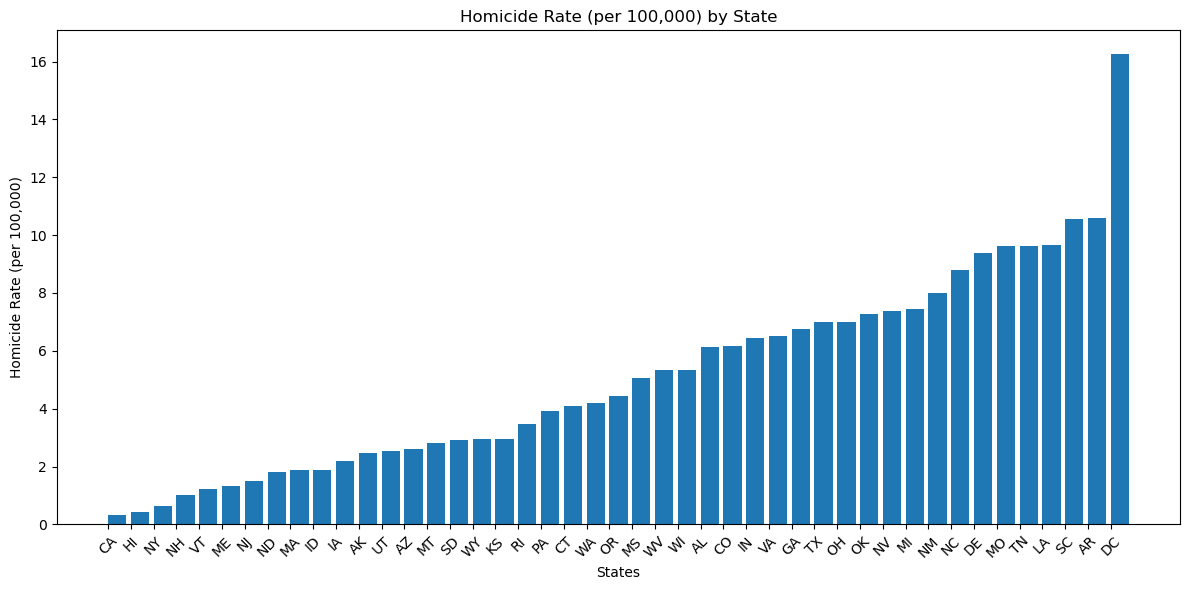

In [21]:
# Generate a bar plot showing the homicide rate by state
plt.figure(figsize=(12,6))
plt.bar(final_data["Abbreviation"],final_data["Homicide Rate (per 100,000)"],align="edge",)

plt.xlabel('States')
plt.ylabel('Homicide Rate (per 100,000)')
plt.title('Homicide Rate (per 100,000) by State')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/HomBar.png")
plt.show()

This visualization allows us to easily see the states with the highest and lowest homicide rates. 

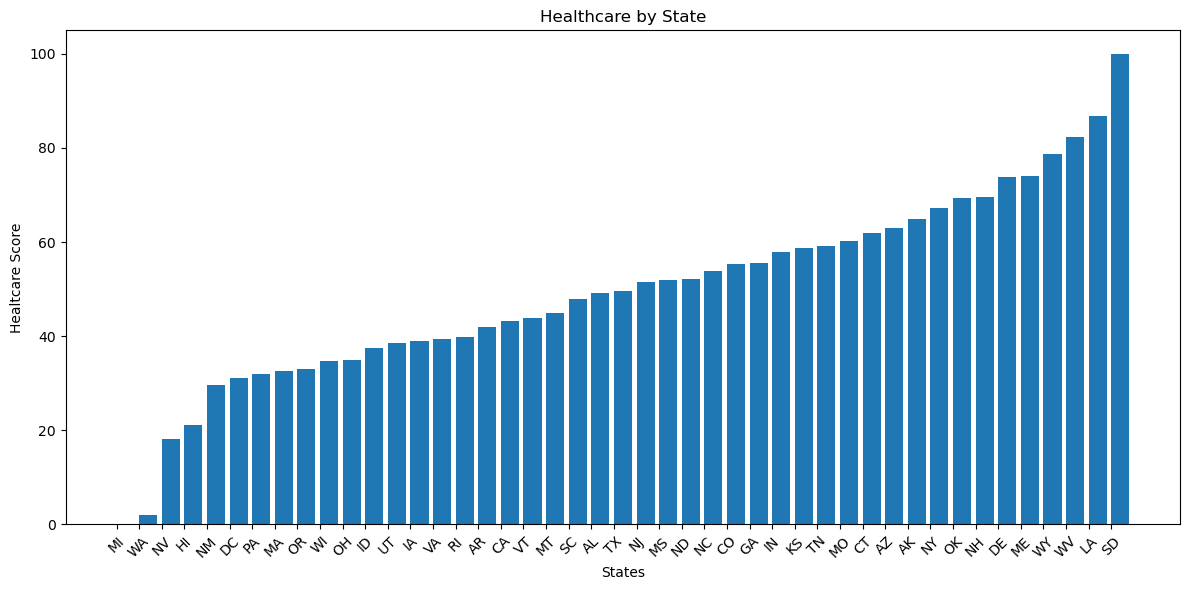

In [22]:
# Sort data by Healthcare Score
final_data_sorted_healthcare = final_data.sort_values("Healthcare Score", ascending = True)
# Generate a bar plot showing Healthcare Score by state
plt.figure(figsize=(12,6))
plt.bar(final_data_sorted_healthcare["Abbreviation"],final_data_sorted_healthcare["Healthcare Score"],align="edge",)

plt.xlabel('States')
plt.ylabel('Healtcare Score')
plt.title("Healthcare by State")

plt.xticks(rotation=45)
plt.savefig("plots/HealthBar.png")
plt.tight_layout()
plt.show()

Michigan has the best healthcare costs, with a score of 0. Followed by Washington. These two states are much lower that the following two states, Nevada and Hawaii. South Dakota has the highest healthcare costs, with a score of 100. 

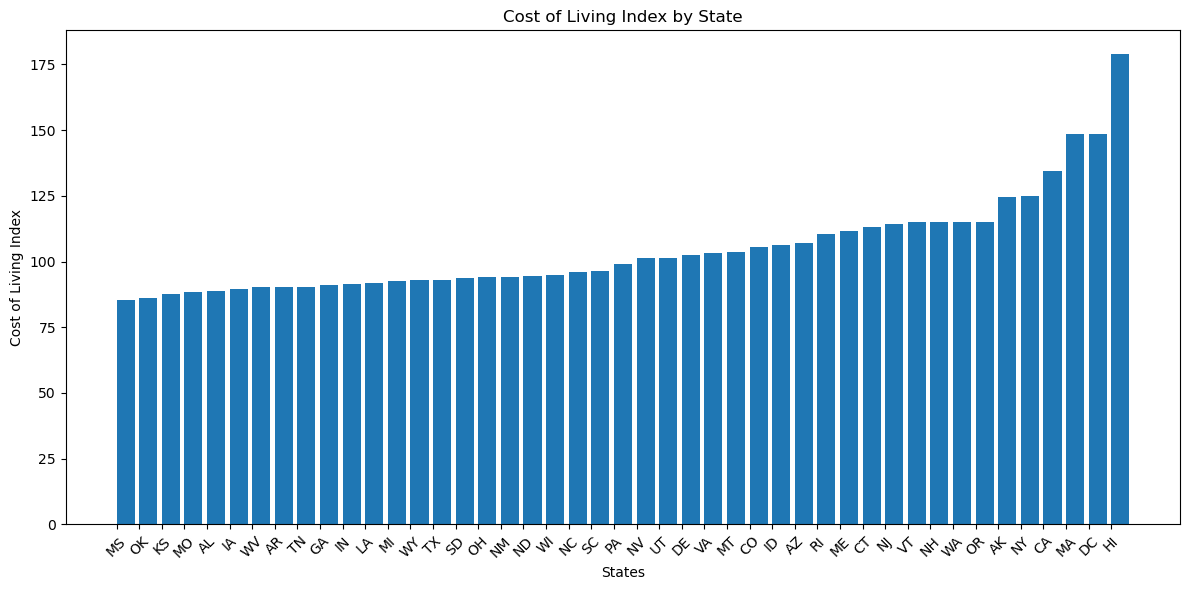

In [23]:
# Sort the data by Cost of Living Index
final_data_sorted_costofliving = final_data.sort_values("Cost of Living Index")

# Generate a bar plot Cost of Living Index by state
plt.figure(figsize=(12,6))
plt.bar(final_data_sorted_costofliving["Abbreviation"],final_data_sorted_costofliving["Cost of Living Index"],align="edge",)

plt.xlabel('States')
plt.ylabel('Cost of Living Index')
plt.title('Cost of Living Index by State')

plt.xticks(rotation=45)
plt.savefig("plots/livingBar.png")
plt.tight_layout()
plt.show()

In the cost of living data, states that have a score below 100 have cost of living lower than the United States average. A score over 100 means that the cost of living is higher than the national average. Hawaii is far and away the state with the highest cost of living, which makes sense as it is an island. Missisippi has the best cost of living, but not by much. 

### Scatterplots

In [24]:
# Caluculate correlations (r values) for each plot
a=round(st.pearsonr(final_data["Healthcare Score"],final_data["Cost of Living Index"])[0],2)
b=round(st.pearsonr(final_data["Healthcare Score"],final_data["Homicide Rate (per 100,000)"])[0],2)
c=round(st.pearsonr(final_data["Homicide Rate (per 100,000)"],final_data["Cost of Living Index"])[0],2)

#### Healthcare Score vs Cost of Living Index

The correlation between healthcare score and cost of living index is -0.28
The p-value is 0.060192331390816686


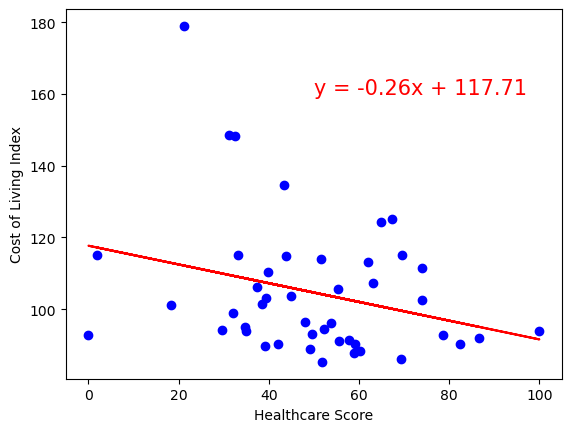

In [25]:
print(f"The correlation between healthcare score and cost of living index is {a}")

(slope,intercept,rvalue,pvalue,stderr) = st.linregress(final_data["Healthcare Score"],final_data["Cost of Living Index"]) 
regress_value=final_data["Healthcare Score"]*slope+intercept
line_eq= "y = " +str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(final_data["Healthcare Score"],final_data["Cost of Living Index"],marker="o",facecolor="blue")
plt.xlabel("Healthcare Score")
plt.ylabel("Cost of Living Index")
plt.plot(final_data["Healthcare Score"],regress_value,"r-")
plt.annotate(line_eq,(50,160),fontsize=15,color="red")
print(f"The p-value is {pvalue}")
plt.savefig("plots/health_vs_coli.png")
plt.show()

With a p-value greater than .05, we cannot reject the null hypothesis that cost of living has no relationship with healthcare costs. 

The correlation between healthcare score and homicide rate is -0.06
the p-value is 0.6761979143624888


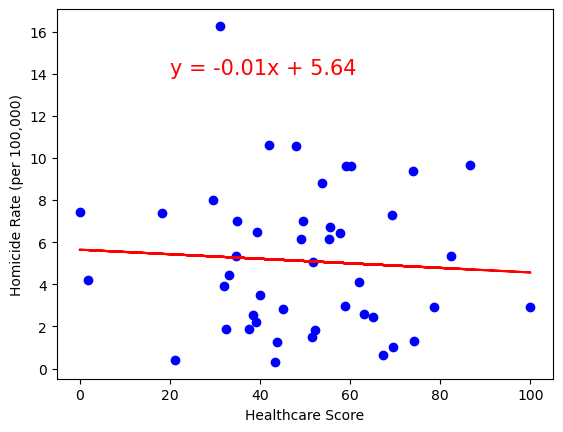

In [26]:
print(f"The correlation between healthcare score and homicide rate is {b}")

(slope,intercept,rvalue,pvalue,stderr) = st.linregress(final_data["Healthcare Score"],final_data["Homicide Rate (per 100,000)"]) 
regress_value=final_data["Healthcare Score"]*slope+intercept
line_eq= "y = " +str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(final_data["Healthcare Score"],final_data["Homicide Rate (per 100,000)"],marker="o",facecolor="blue")
plt.xlabel("Healthcare Score")
plt.ylabel("Homicide Rate (per 100,000)")
plt.plot(final_data["Healthcare Score"],regress_value,"r-")
plt.annotate(line_eq,(20,14),fontsize=15,color="red")
print(f"the p-value is {pvalue}")
plt.savefig("plots/health_vs_homicide.png")
plt.show()

With a p-value greater than .05, we cannot reject the null hypothesis that homicide rate has no relationship with healthcare costs. 

The correlation between homicide rate and cost of living index is -0.3
the p-value is 0.04627352628453946


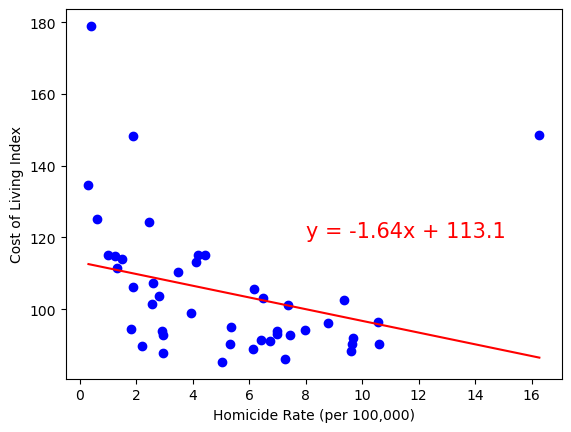

In [27]:
print(f"The correlation between homicide rate and cost of living index is {c}")

(slope,intercept,rvalue,pvalue,stderr) = st.linregress(final_data["Homicide Rate (per 100,000)"],final_data["Cost of Living Index"]) 
regress_value=final_data["Homicide Rate (per 100,000)"]*slope+intercept
line_eq= "y = " +str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(final_data["Homicide Rate (per 100,000)"],final_data["Cost of Living Index"],marker="o",facecolor="blue")
plt.xlabel("Homicide Rate (per 100,000)")
plt.ylabel("Cost of Living Index")
plt.plot(final_data["Homicide Rate (per 100,000)"],regress_value,"r-")
plt.annotate(line_eq,(8,120),fontsize=15,color="red")
print(f"the p-value is {pvalue}")
plt.savefig("plots/homicide_vs_coli.png")
plt.show()

With a p-value less than .05, we can reject the null hypothesis and conclude that there is a relationship between cost of living and homicide rate. As cost of living increases, the homicide rate decreases. 

### Pie Charts

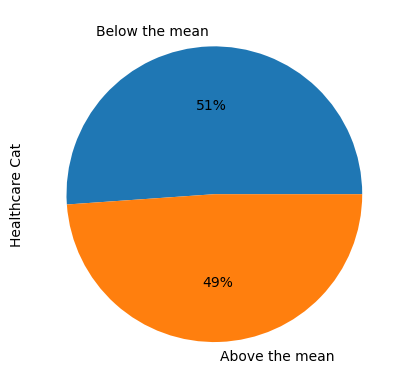

In [28]:
bins_health=[0,final_data["Healthcare Score"].mean(),final_data["Healthcare Score"].max()]
labels=["Below the mean","Above the mean"]

final_data_2=final_data.copy()

final_data_2["Healthcare Cat"]=pd.cut(final_data_2["Healthcare Score"],bins_health,labels=labels,include_lowest=True)
final_data_2.head()


health_graf=final_data_2.groupby("Healthcare Cat")
data_healt_df=health_graf["Healthcare Cat"].count()

pie_chart_health=data_healt_df.plot(kind="pie",y="Healthcare Cat",autopct='%1.0f%%')
plt.savefig("plots/HealthPie.png")
#plt.axis("equal")
plt.show()

The mean is an accurate representation of the middle of the data, close to 50% is above and below. 

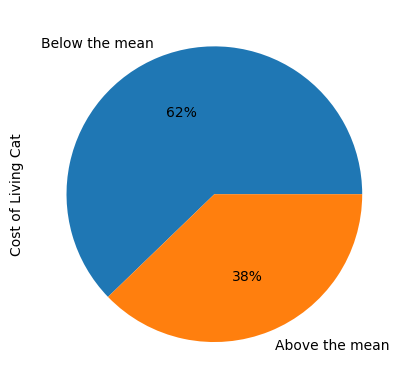

In [29]:
bins_cost=[0,final_data["Cost of Living Index"].mean(),final_data["Cost of Living Index"].max()]
labels=["Below the mean","Above the mean"]

final_data_3=final_data.copy()

final_data_3["Cost of Living Cat"]=pd.cut(final_data_3["Cost of Living Index"],bins_cost, labels=labels,include_lowest=True)
final_data_3.head()


cost_graf=final_data_3.groupby("Cost of Living Cat")
data_cost_df=cost_graf["Cost of Living Cat"].count()

pie_chart_cost=data_cost_df.plot(kind="pie",y="Cost of Living Cat",autopct='%1.0f%%')
plt.savefig("plots/CostPie.png")
#plt.axis("equal")
plt.show()

The mean is not an accurate representation of the middle of the data. Median may be a better representation. This means we likely have outliers above the mean. 

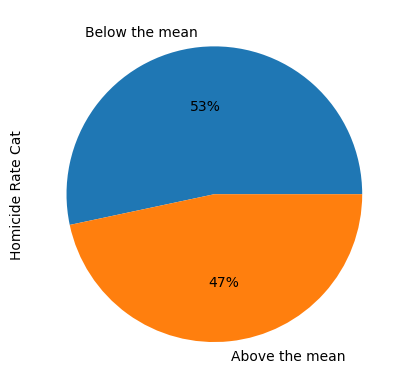

In [30]:
bins_homicide=[0,final_data["Homicide Rate (per 100,000)"].mean(),final_data["Homicide Rate (per 100,000)"].max()]
labels=["Below the mean","Above the mean"]

final_data_4=final_data.copy()

final_data_4["Homicide Rate Cat"]=pd.cut(final_data_4["Homicide Rate (per 100,000)"],bins_homicide, labels=labels,include_lowest=True)


homicide_graf=final_data_4.groupby("Homicide Rate Cat")
data_homicide_df=homicide_graf["Homicide Rate Cat"].count()

pie_chart_homicide=data_homicide_df.plot(kind="pie",y="Homicide Rate Cat",autopct='%1.0f%%')
plt.savefig("plots/HomicidePie.png")
#plt.axis("equal")
plt.show()

The mean is an accurate representation of the middle of the data, close to 50% is above and below. 

### Box and Whisker Plots

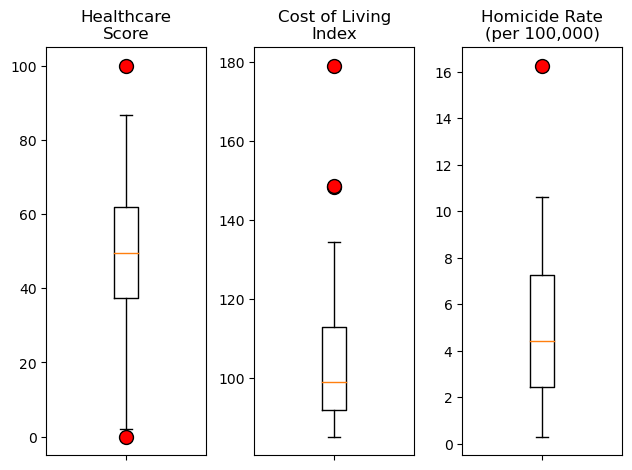

In [31]:

fig1,axs =plt.subplots(1,3)

axs[0].set_title("Healthcare\nScore")
axs[0].boxplot(final_data["Healthcare Score"],flierprops=dict(markerfacecolor="red",markersize=10))
axs[0].set_xticklabels("")

axs[1].set_title("Cost of Living\nIndex")
axs[1].boxplot(final_data["Cost of Living Index"],flierprops=dict(markerfacecolor="red",markersize=10))
axs[1].set_xticklabels("")

axs[2].set_title("Homicide Rate\n(per 100,000)")
axs[2].boxplot(final_data["Homicide Rate (per 100,000)"],flierprops=dict(markerfacecolor="red",markersize=10))
axs[2].set_xticklabels("")

fig1.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
plt.savefig("plots/whiskers.png")

This box and whisker plot shows the outliers in out data. The highest and lowest of the healthcare scores (South Dakota and Michigan, respectively) are outliers. The three highest of the cost of living index (Hawaii, Washington DC, and Maryland) are outliers. Finally, Washington, DC is an outlier in homicide rate. 

Further analysis is provided in the jupyter notebook state_graf. 